<a href="https://colab.research.google.com/github/yiwenwangANU/pytorch_review/blob/main/06_Fine_tuning_pretrained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import, set up GPU and download data

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision

import os
import kagglehub
import random
import glob

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR

In [41]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Download latest version
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

print("Path to dataset files:", path)

100%|██████████| 1.98G/1.98G [00:18<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8


## Explore data

In [ ]:
for root, dirs, file in os.walk(path):
  print(f'Current directory: {root}')
  print(f'Subdirs: {dirs}')
  print(f'Number of Files: {len(file)}, Files: {file}')

In [31]:
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")

In [14]:
for fruit in os.listdir(train_dir):
  curr_path = os.path.join(train_dir, fruit)
  images_number = len(glob.glob(curr_path + '/*.jpeg') + glob.glob(curr_path + '/*.jpg') + glob.glob(curr_path + '/*.png'))
  print(f'Number of {fruit}: {images_number}')

Number of watermelon: 83
Number of lettuce: 95
Number of eggplant: 81
Number of capsicum: 84
Number of spinach: 94
Number of grapes: 94
Number of turnip: 93
Number of raddish: 79
Number of cauliflower: 76
Number of pear: 88
Number of apple: 67
Number of ginger: 68
Number of bell pepper: 88
Number of beetroot: 87
Number of onion: 93
Number of sweetcorn: 88
Number of corn: 86
Number of lemon: 81
Number of banana: 74
Number of cucumber: 88
Number of carrot: 81
Number of peas: 96
Number of kiwi: 88
Number of sweetpotato: 69
Number of orange: 68
Number of paprika: 82
Number of cabbage: 87
Number of soy beans: 96
Number of pomegranate: 78
Number of jalepeno: 87
Number of potato: 75
Number of garlic: 91
Number of tomato: 92
Number of chilli pepper: 81
Number of mango: 84
Number of pineapple: 98


In [15]:
#label encode aniaml classes
label_to_fruit = {idx:fruit for idx, fruit in enumerate(os.listdir(train_dir))}
label_to_fruit

{0: 'watermelon',
 1: 'lettuce',
 2: 'eggplant',
 3: 'capsicum',
 4: 'spinach',
 5: 'grapes',
 6: 'turnip',
 7: 'raddish',
 8: 'cauliflower',
 9: 'pear',
 10: 'apple',
 11: 'ginger',
 12: 'bell pepper',
 13: 'beetroot',
 14: 'onion',
 15: 'sweetcorn',
 16: 'corn',
 17: 'lemon',
 18: 'banana',
 19: 'cucumber',
 20: 'carrot',
 21: 'peas',
 22: 'kiwi',
 23: 'sweetpotato',
 24: 'orange',
 25: 'paprika',
 26: 'cabbage',
 27: 'soy beans',
 28: 'pomegranate',
 29: 'jalepeno',
 30: 'potato',
 31: 'garlic',
 32: 'tomato',
 33: 'chilli pepper',
 34: 'mango',
 35: 'pineapple'}

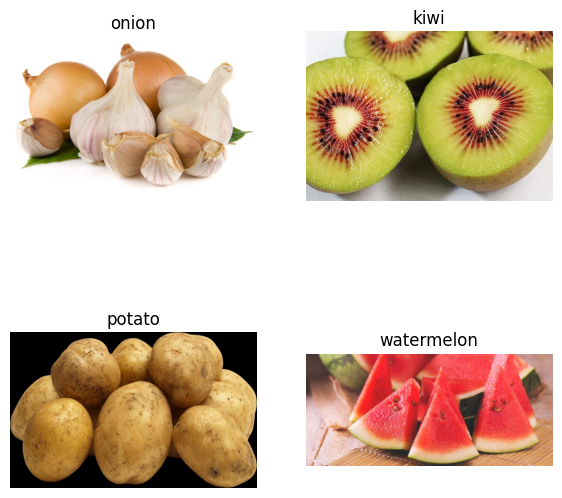

In [22]:
def plotRandomImages(rootdir):
  images = glob.glob(rootdir + "/**/*.jpeg") + glob.glob(rootdir + "/**/*.jpg") + glob.glob(rootdir + "/**/*.png")
  plt.figure(figsize=(7, 7))
  for i in range(4):
    random_image = random.choice(images)
    img = Image.open(random_image)
    plt.subplot(2, 2, i+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(random_image.split("/")[-2])
  plt.show()

plotRandomImages(train_dir)

## Create Dataset and DataLoader

In [29]:
class FruitDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.image_paths = []
    self.labels = []
    self.label_dict = {idx:label for idx,label in enumerate(os.listdir(self.root_dir))} # {0:'watermelon',1:'lettuce',2:'eggplant', ...}
    self.count = 0

    for idx, label in self.label_dict.items():
      class_dir = os.path.join(root_dir, label)
      for file in os.listdir(class_dir):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
          self.count += 1
          self.image_paths.append(os.path.join(class_dir, file))
          self.labels.append(idx)
      self.count = 0

  def __len__(self):
    return len(self.labels)


  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx]).convert("RGB")
    label = self.labels[idx]
    if self.transform:
      image = self.transform(image)
    return image, label

in fine tuning, apply the same transform to the dataset as the chosen model

In [27]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [28]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [32]:
train_dataset = FruitDataset(root_dir=train_dir, transform=auto_transforms)
test_dataset = FruitDataset(root_dir=test_dir, transform=auto_transforms)

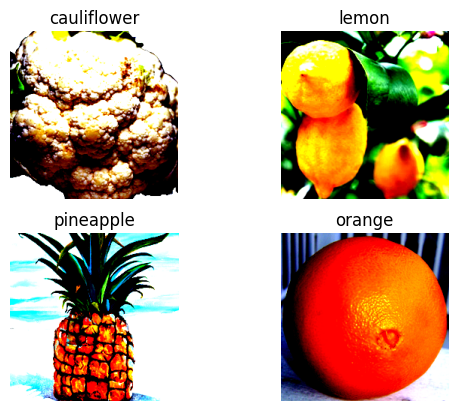

In [36]:
def plotRandomDataset(dataset):
  random_samples_idx = random.sample(range(len(dataset)), k=4)
  for i, sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[sample][0], dataset[sample][1]
    targ_image_adjust = targ_image.permute(1, 2, 0)
    plt.subplot(2, 2, i+1)
    plt.axis('off')
    plt.imshow(targ_image_adjust)
    fruit_class = label_to_fruit[targ_label]
    plt.title(fruit_class)

plotRandomDataset(train_dataset)

In [38]:
# Define batch size
batch_size = 64

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Getting a pretrained model

In [39]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 34.8MB/s]


In [42]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(64, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224]    [64, 1000]           --                   True
├─Sequential (features)                                      [64, 3, 224, 224]    [64, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [64, 3, 224, 224]    [64, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112]   [64, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [64, 32, 112, 112]   [64, 16, 112

In [44]:
# Get the length of class_names (one output unit for each class)
output_shape = len(label_to_fruit)
num_features = model.classifier[-1].in_features
# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=num_features,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

## Train the model on classifier

In [53]:
initial_epochs = 5
fine_tune_epochs = 5

In [49]:
def train(model: torch.nn.Module,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          epoches: int = 10):

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
    }
  for epoch in range(epoches):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = len(train_loader.dataset)
    for X_train, y_train in train_loader:
      X_train, y_train = X_train.to(device), y_train.to(device)
      y_logits = model(X_train)
      loss = loss_fn(y_logits, y_train)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      train_pred = torch.argmax(y_logits, dim=1)
      train_correct += (train_pred == y_train).sum().item()
    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = len(test_loader.dataset)
    with torch.inference_mode():
      for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        test_logits = model(X_test)
        loss = loss_fn(test_logits, y_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss += loss.item()
        test_correct += (test_pred == y_test).sum().item()
    test_loss /= len(test_loader)
    test_acc = test_correct / test_total
    scheduler.step()

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    print(f'epoch: {epoch}, train_loss: {train_loss:.4f}, train accuracy: {train_acc:.4f}, test loss: {test_loss:.4f}, test accuracy: {test_acc:.4f}')
  return results

In [46]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [47]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(64, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224]    [64, 36]             --                   Partial
├─Sequential (features)                                      [64, 3, 224, 224]    [64, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [64, 3, 224, 224]    [64, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112]   [64, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [64, 32, 112, 112]   [64, 

In [54]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [55]:
train_on_classifier = train(model=model,
                                train_loader=train_loader,
                                test_loader=test_loader,
                                loss_fn=loss_fn,
                                optimizer = optimizer,
                                scheduler = scheduler,
                                epoches=initial_epochs)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch: 0, train_loss: 2.5398, train accuracy: 0.4774, test loss: 1.2069, test accuracy: 0.8552
epoch: 1, train_loss: 1.2738, train accuracy: 0.7778, test loss: 0.6353, test accuracy: 0.9053
epoch: 2, train_loss: 0.8882, train accuracy: 0.8193, test loss: 0.4394, test accuracy: 0.9276
epoch: 3, train_loss: 0.7170, train accuracy: 0.8443, test loss: 0.3525, test accuracy: 0.9359
epoch: 4, train_loss: 0.6010, train accuracy: 0.8713, test loss: 0.2930, test accuracy: 0.9526


## Fine tune the model

In [56]:
# Unfreeze all (or part of) the model layers
for param in model.parameters():
    param.requires_grad = True

In [57]:
# Use a lower learning rate for fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [58]:
fine_tune_model = train(model=model,
                        train_loader=train_loader,
                        test_loader=test_loader,
                        loss_fn=loss_fn,
                        optimizer = optimizer,
                        scheduler = scheduler,
                        epoches=fine_tune_epochs)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch: 0, train_loss: 0.5178, train accuracy: 0.8915, test loss: 0.2685, test accuracy: 0.9499
epoch: 1, train_loss: 0.4641, train accuracy: 0.8976, test loss: 0.2476, test accuracy: 0.9526
epoch: 2, train_loss: 0.4339, train accuracy: 0.9075, test loss: 0.2318, test accuracy: 0.9582
epoch: 3, train_loss: 0.4130, train accuracy: 0.9034, test loss: 0.2172, test accuracy: 0.9610
epoch: 4, train_loss: 0.3809, train accuracy: 0.9178, test loss: 0.2096, test accuracy: 0.9554


## Evaluate the model

In [59]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(10, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

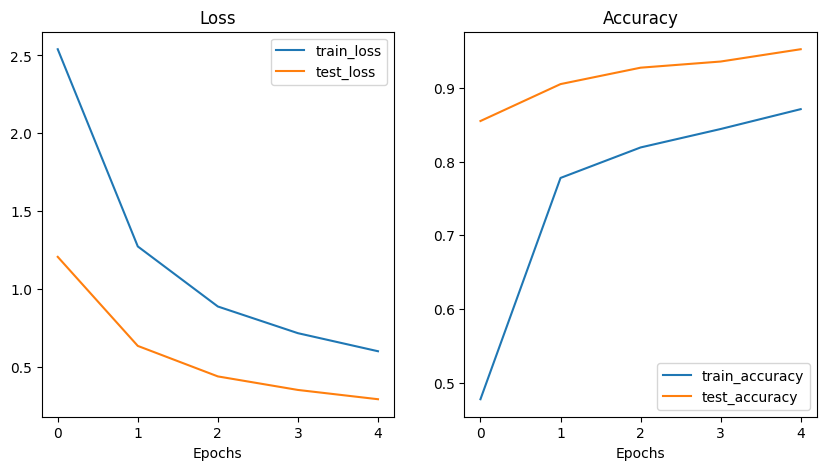

In [63]:
plot_loss_curves(train_on_classifier)

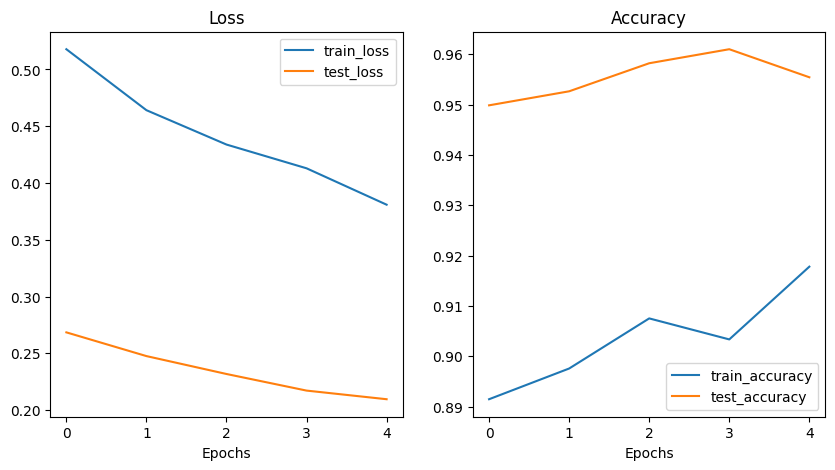

In [62]:
plot_loss_curves(fine_tune_model)